In [ ]:
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install textblob
%pip install gensim
%pip install wordcloud
%pip install networkx
%pip install spacy
%pip install scikit-learn
%pip install pyLDAvis
%pip install pyLDAvis.gensim
%pip install pyLDAvis.gensim_models
%pip install pyLDAvis
%pip install pyLDAvis.gensim_models
%pip install pyLDAvis.gensim

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
#from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from gensim.matutils import sparse2full

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import networkx as nx
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import spacy

from collections import Counter

from gensim.corpora import Dictionary
from gensim.models import LdaModel

from wordcloud import WordCloud


# Unmount the drive
#drive.flush_and_unmount()
#print('Drive unmounted')





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached spacy-3.8.2.tar.gz (1.3 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [91 lines of output]
      Ignoring numpy: markers 'python_version >= "3.9"' don't match your environment
        Using cached setuptools-75.3.2-py3-none-any.whl.metadata (6.9 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached cymem-2.0.11.tar.gz (10 kB)
        In

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/filiporlikowski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/filiporlikowski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/filiporlikowski/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
UsageError: Line magic function `%import` not found.


# **Load and Preprocess Data**

In [22]:
name = "Counter-Strike 2"
# File path
#file_path = '/content/drive/My Drive/reviews_with_metadata.csv'
file_path = 'MINITRI_Project_2/most_recent/reviews_Counter-Strike_2.csv'
# Step 1: Load Data
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print("File not found. Please check the file path.")

# Step 2: Clean `Hours Played`
data['Hours Played'] = data['Hours Played'].replace(',', '', regex=True).astype(float)

# Step 3: Drop Rows with Missing Reviews
data = data.dropna(subset=['Review'])

# Step 4: Define Text Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Replace special characters with a space
    text = re.sub(r"[^\w\s]", " ", text)  # Keep only words and spaces
    # Replace numeric characters with a space
    text = re.sub(r"\d+", " ", text)
    # Remove non-ASCII and non-Cyrillic characters
    text = re.sub(r"[^\x00-\x7F\u0400-\u04FF\s]", " ", text)
    # Remove multiple consecutive spaces
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenize text
    tokens = word_tokenize(text)
    # Load stopwords and add custom stopwords
    custom_stopwords = set(stopwords.words('english'))
    custom_stopwords.update(['o', 'etc', 'would', 'could', 'us', 'the', 'to', 'of', 'in', 'it', 'and', 'this', 'that', 'for'])  # Add custom meaningless words
    # Remove stopwords and short tokens or stand-alone letters
    tokens = [word for word in tokens if word not in custom_stopwords and len(word) > 1]
    # Filter out stand-alone letters explicitly
    tokens = [word for word in tokens if len(word) > 1 or word.isnumeric()]
    # Join tokens back into a single string
    return ' '.join(tokens)


# Step 5: Apply Text Preprocessing
data['Processed_Review'] = data['Review'].apply(preprocess_text)

# Step 6: Drop Empty Processed Reviews
data = data[data['Processed_Review'].str.strip() != ""]

# Step 7: Convert `Date` Column to Datetime Format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Display the first few rows of the processed data
data.head()


,Date,Review,Hours Played,Likes,Replies,Recommendation,Processed_Review
0,2016-10-19,Where can I get the English version ?,2711.8,7334249450,0,Recommended,get english version
1,2020-11-02,The time I spent playing this game could've be...,1895.9,21331564346,0,Recommended,time spent playing game spent studying applyin...
2,2019-11-04,Underage Gambling,8154.3,180222395,0,Recommended,underage gambling
3,2023-07-15,>see a guy >hit every shot >run out of bullets...,11.9,90537246,0,Recommended,see guy hit every shot run bullets turns aroun...
4,2023-08-14,>aim at corner >wait for enemy >turn away for ...,172.1,91832445,0,Recommended,aim corner wait enemy turn away seconds comes ...


# **Text Tokenization and Preparation**

In [23]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Step 8: Tokenize Processed Reviews
data['Tokenized_Review'] = data['Processed_Review'].apply(word_tokenize)

# Step 9: Build Vocabulary
def build_vocab_and_filter(data, min_word_freq=2):
    # Flatten all tokenized reviews to get all tokens
    all_tokens = [token for tokens in data['Tokenized_Review'] for token in tokens]
    vocab_counter = Counter(all_tokens)
    # Filter words by minimum frequency
    vocab = {word for word, count in vocab_counter.items() if count >= min_word_freq}
    return vocab

# Apply vocabulary filtering
min_word_freq = 2
vocab = build_vocab_and_filter(data, min_word_freq)

# Step 10: Filter Tokenized Reviews
data['Filtered_Review'] = data['Tokenized_Review'].apply(
    lambda tokens: [word for word in tokens if word in vocab]
)

# Step 11: Reconstruct Cleaned Documents
documents = data['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))

# Step 12: Prepare Metadata
metadata = data.drop(columns=['Review', 'Processed_Review', 'Tokenized_Review', 'Filtered_Review'])

# Step 13: Save Outputs (Optional)
documents.to_csv(f'processed_{name}_documents.csv', index=False, header=['Documents'])
metadata.to_csv(f'processed_{name}_metadata.csv', index=False)

# Step 14: Display Samples
print("Sample Processed Documents:")
print(documents.head())

print("\nVocabulary Size:", len(vocab))
print("Sample Vocabulary:", list(vocab)[:10])

print("\nSample Metadata:")
print(metadata.head())


Sample Processed Documents:
0                                  get english version
1    time spent playing game spent studying applyin...
2                                    underage gambling
3    see guy hit every shot run bullets turns aroun...
4    aim corner wait enemy turn away seconds comes ...
Name: Filtered_Review, dtype: object

Vocabulary Size: 2293
Sample Vocabulary: ['caring', 'sports', 'wtf', 'disability', 'honestly', 'elo', 'slogan', 'seriously', 'quitter', 'tbh']

Sample Metadata:
        Date  Hours Played        Likes  Replies Recommendation
0 2016-10-19        2711.8   7334249450        0    Recommended
1 2020-11-02        1895.9  21331564346        0    Recommended
2 2019-11-04        8154.3    180222395        0    Recommended
3 2023-07-15          11.9     90537246        0    Recommended
4 2023-08-14         172.1     91832445        0    Recommended


# **Structural Topic Modeling (STM)**
Building STM models for different numbers of topics (K = 2, 3, 4, 5, 6).
Extracted key terms for each topic using labelTopics.
Visualized top topics for each model.

Sample dictionary (first 10 tokens): ['english', 'get', 'version', 'anger', 'applying', 'autistic', 'becoming', 'better', 'borderline', 'casual']
Sample corpus (first 5 documents): [[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 1), (50, 1), (51, 1), (52, 3), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(58, 1), (59, 1)], [(60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1)], [(62, 1), (66, 1), (67, 1), (70, 1), (71, 1), (74, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), 

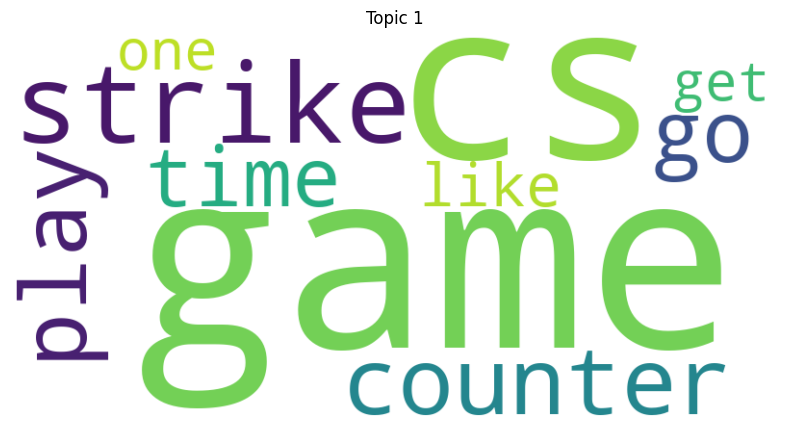

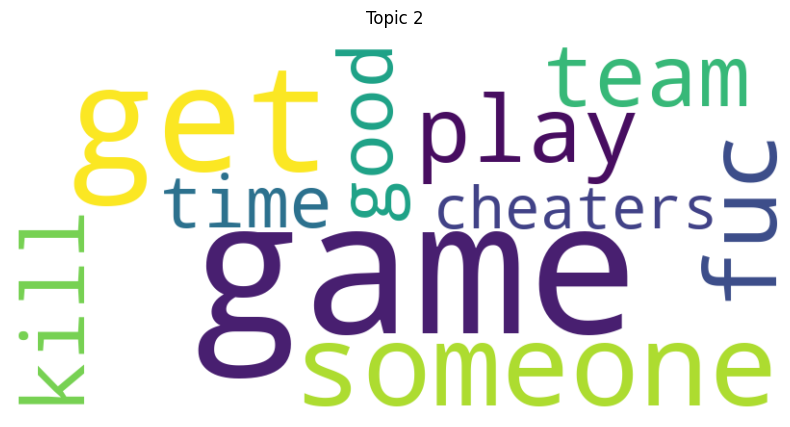

Visualizing 3-Topic Model...


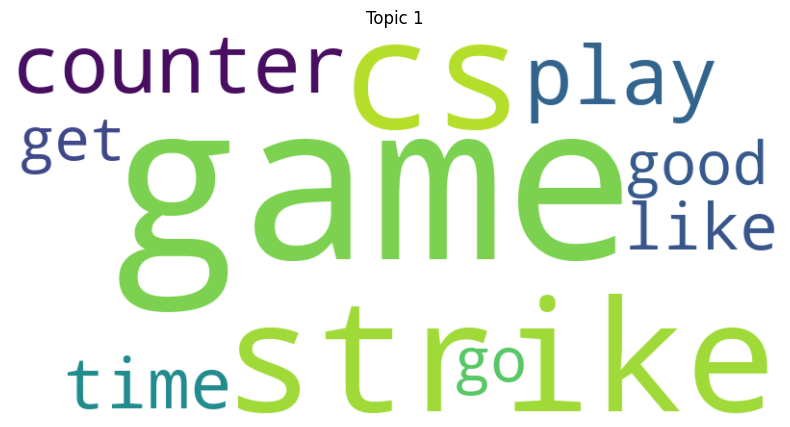

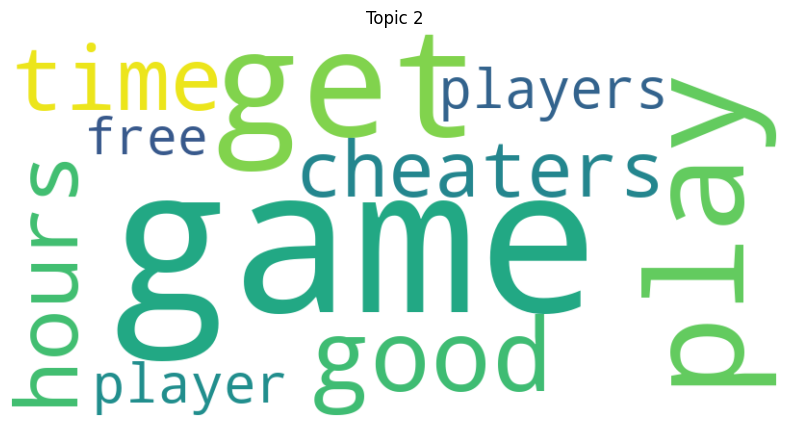

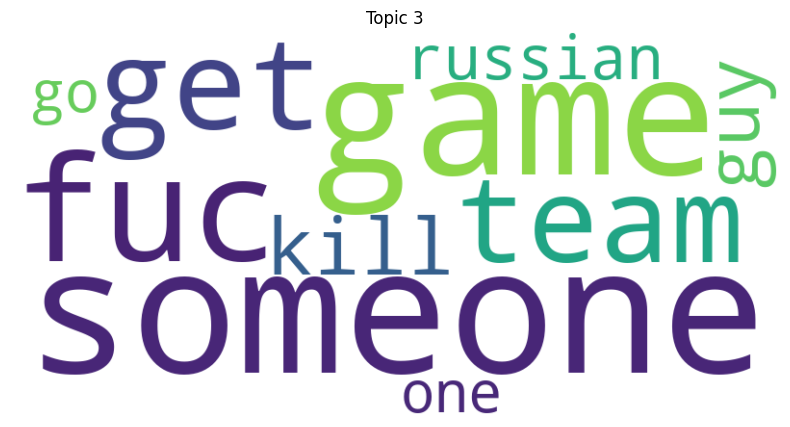

Visualizing 4-Topic Model...


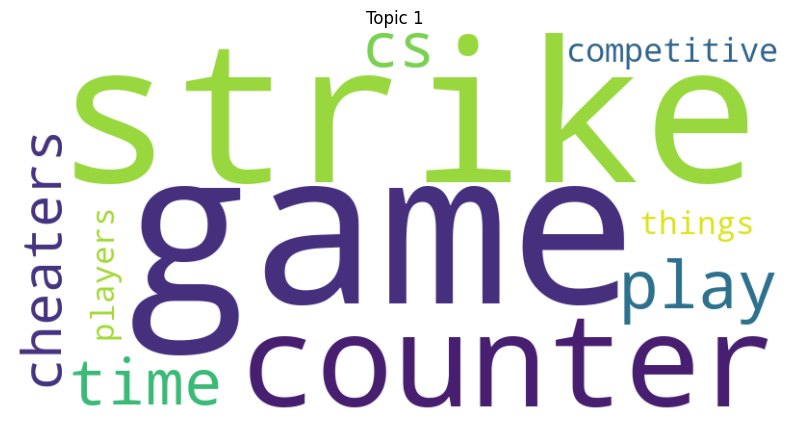

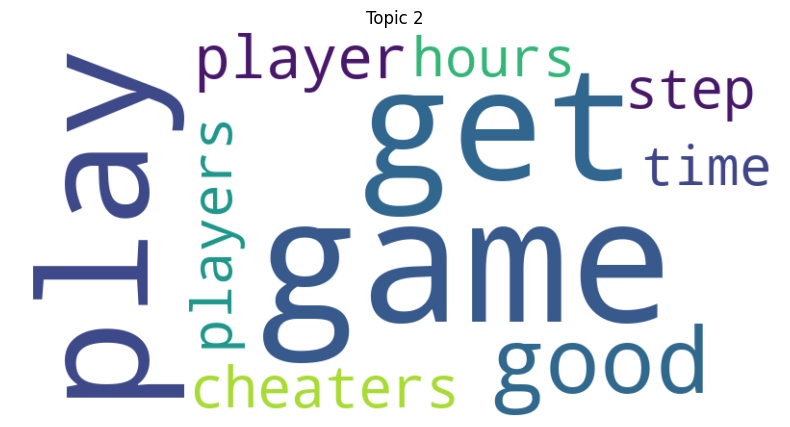

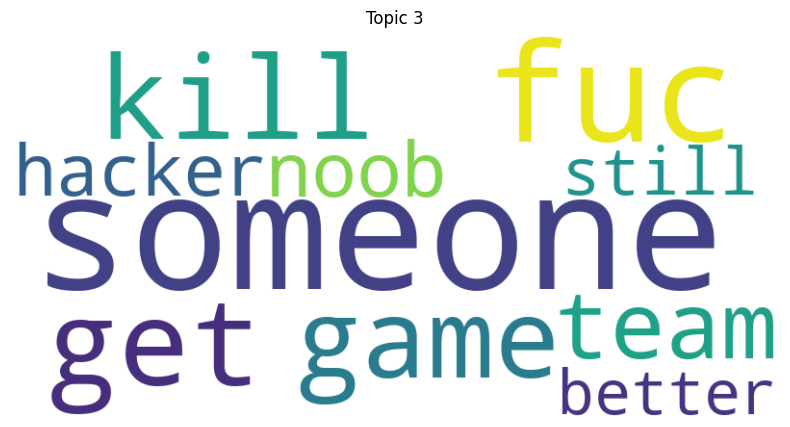

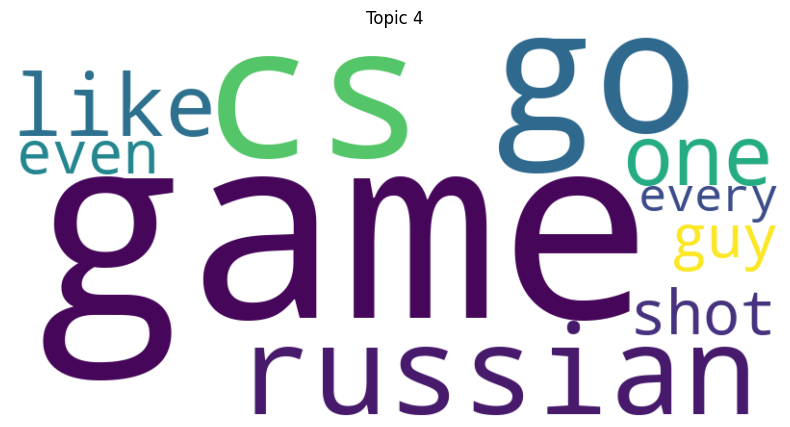

Visualizing 5-Topic Model...


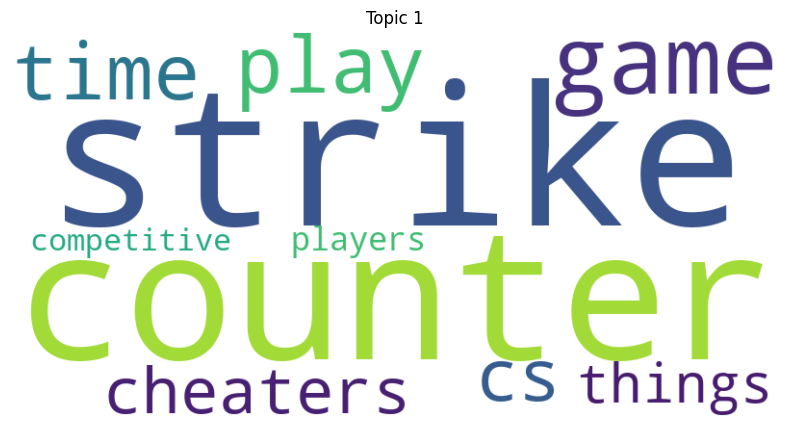

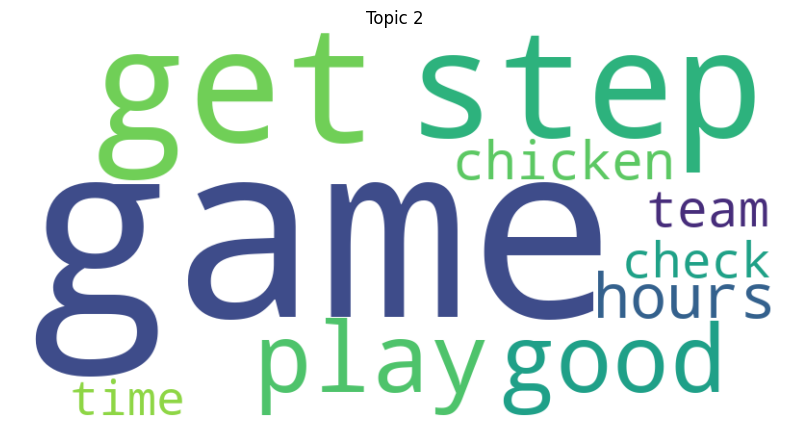

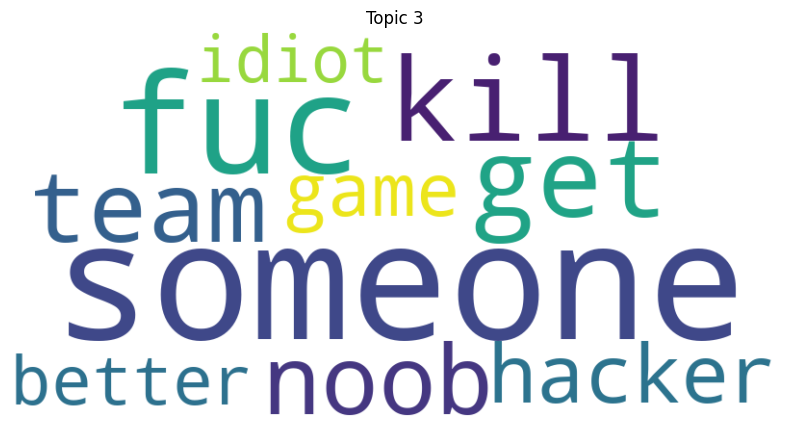

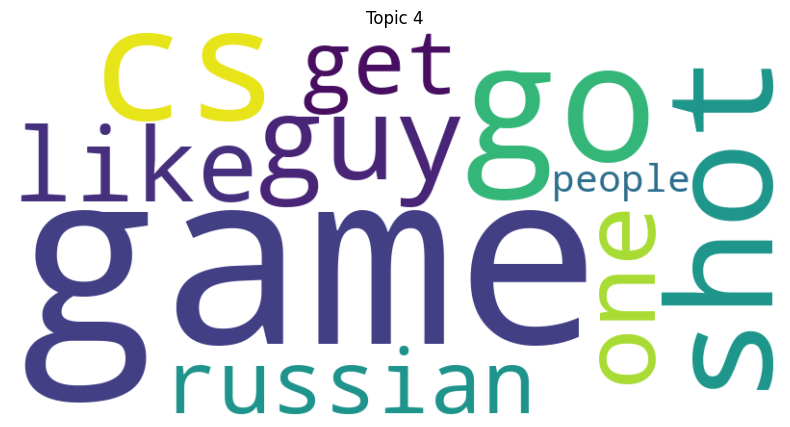

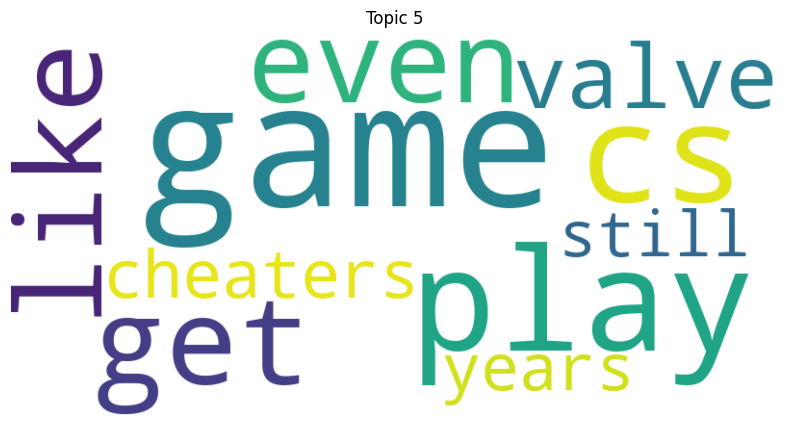

Visualizing 6-Topic Model...


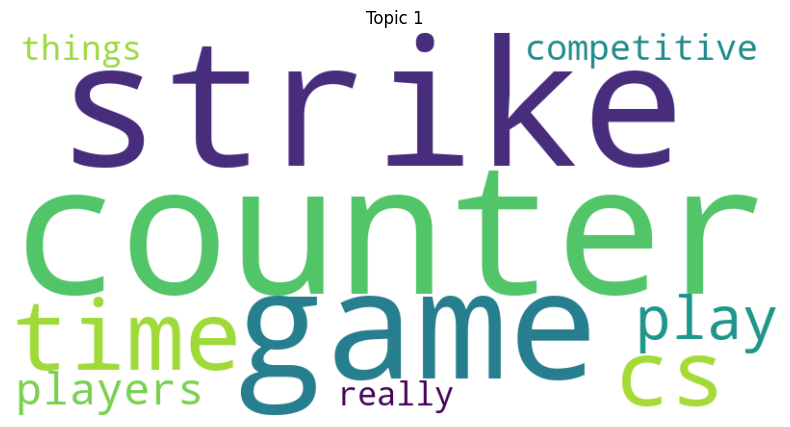

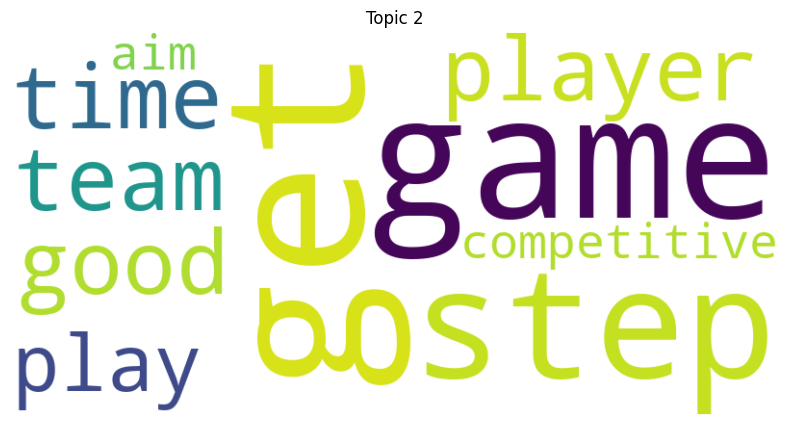

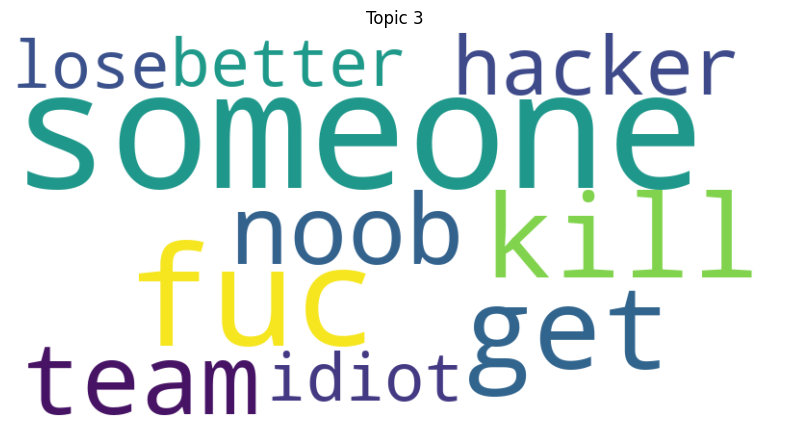

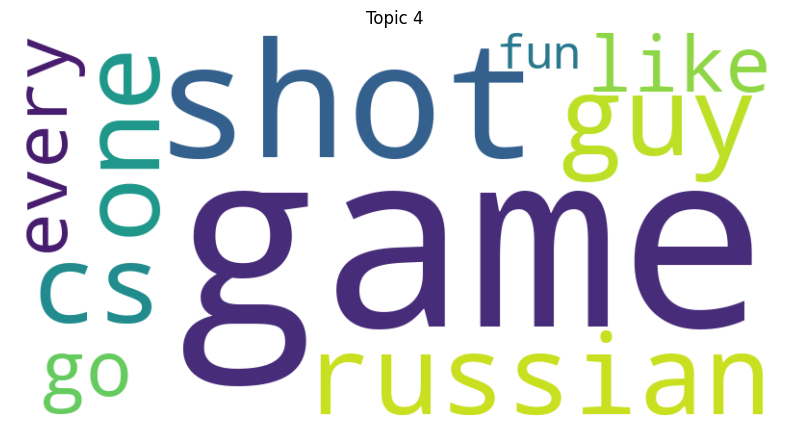

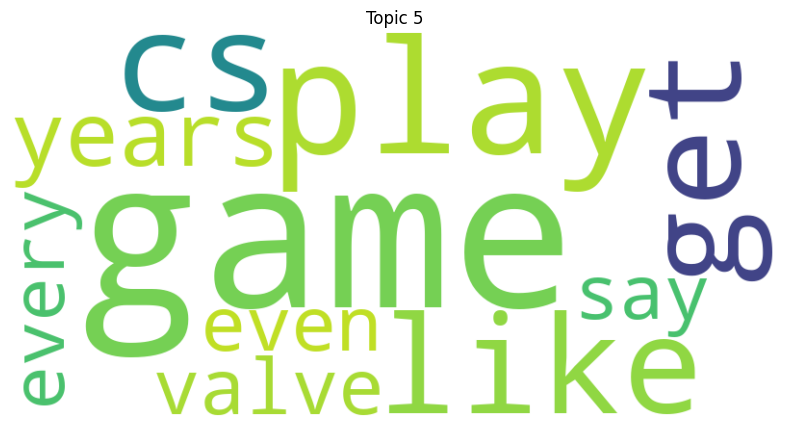

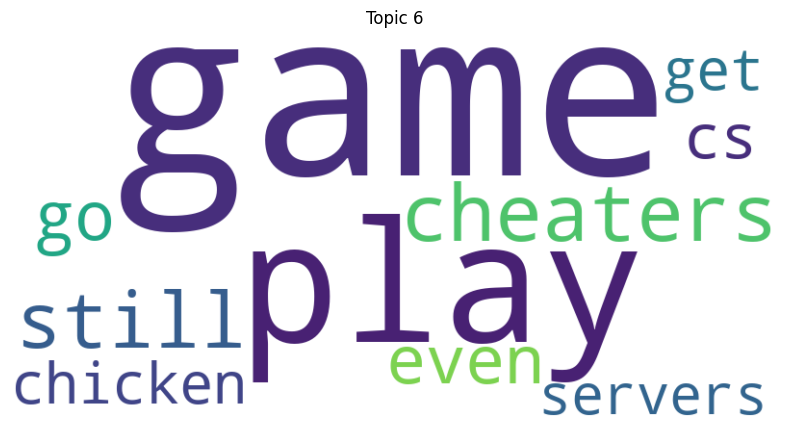

STM modeling and visualization complete!


In [24]:
def prepare_corpus_and_dictionary(documents):
    # Tokenize the documents if not already tokenized
    tokenized_docs = [doc.split() if isinstance(doc, str) else doc for doc in documents]
    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    return dictionary, corpus

# Ensure documents are in a list format
#documents = documents.tolist()  # Convert from Pandas Series to list if needed

# Prepare dictionary and corpus
dictionary, corpus = prepare_corpus_and_dictionary(documents)

print("Sample dictionary (first 10 tokens):", list(dictionary.token2id.keys())[:10])
print("Sample corpus (first 5 documents):", corpus[:5])

# Step 7: Structural Topic Modeling (STM)
from gensim.models.ldamodel import LdaModel

def build_stm_models(corpus, dictionary, num_topics_list):
    models = {}
    for num_topics in num_topics_list:
        print(f"Building model with {num_topics} topics...")
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
        models[num_topics] = model
    return models

# Define the list of topics to model
num_topics_list = [2, 3, 4, 5, 6]
models = build_stm_models(corpus, dictionary, num_topics_list)

# Step 8: Extract and visualize key terms for each model
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_topics(model, num_topics, num_words=10):
    for topic_idx in range(num_topics):
        words = model.show_topic(topic_idx, num_words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_idx + 1}")
        plt.show()

# Visualize topics for each model
for num_topics, model in models.items():
    print(f"Visualizing {num_topics}-Topic Model...")
    visualize_topics(model, num_topics)

print("STM modeling and visualization complete!")

# **Model Comparison**
Model Comparison in Python, we need to evaluate the STM models using Exclusivity and Semantic Coherence metrics, then visualize the results to compare models with different numbers of topics.

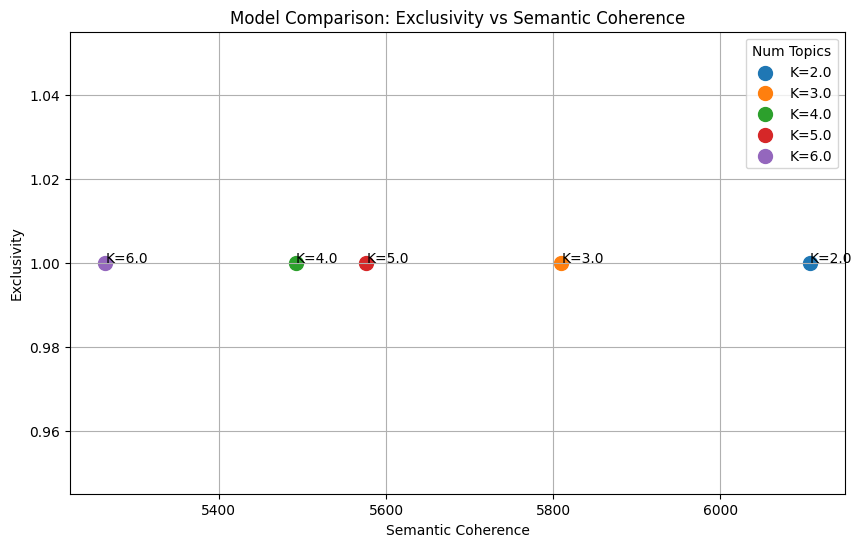

In [25]:
# Function to calculate Exclusivity and Semantic Coherence
def evaluate_model_exclusivity_coherence(models, dictionary, corpus):
    results = []
    for num_topics, model in models.items():
        # Calculate Exclusivity (uniqueness of words in topics)
        exclusivity = []
        for topic_id in range(model.num_topics):
            top_words = model.show_topic(topic_id, topn=20)
            exclusivity.append(len(set([word for word, _ in top_words])) / len(top_words))

        # Semantic Coherence (interpretability of topics)
        semantic_coherence = []
        for topic_id in range(model.num_topics):
            topic_words = [word for word, _ in model.show_topic(topic_id, topn=10)]
            coherence_score = 0
            for word in topic_words:
                word_id = dictionary.token2id.get(word)
                if word_id is not None:
                    word_co_occurrences = [
                        freq for doc in corpus for word_id_doc, freq in doc if word_id_doc == word_id
                    ]
                    coherence_score += sum(word_co_occurrences)
            semantic_coherence.append(coherence_score)

        # Average Metrics for the Model
        avg_exclusivity = np.mean(exclusivity)
        avg_semantic_coherence = np.mean(semantic_coherence)
        results.append({
            "num_topics": num_topics,
            "avg_exclusivity": avg_exclusivity,
            "avg_semantic_coherence": avg_semantic_coherence
        })
    return pd.DataFrame(results)

# Ensure corpus is correctly formatted
# Corpus should be a list of lists with tuples (word_id, frequency)
# Example: [[(0, 2), (1, 3)], [(0, 1), (2, 5)]]
corpus = [dictionary.doc2bow(doc.split()) for doc in documents]

# Call the function to evaluate models
evaluation_results = evaluate_model_exclusivity_coherence(models, dictionary, corpus)

# Plot Exclusivity vs. Semantic Coherence
def plot_model_comparison(evaluation_results):
    plt.figure(figsize=(10, 6))
    for i, row in evaluation_results.iterrows():
        plt.scatter(row['avg_semantic_coherence'], row['avg_exclusivity'], label=f"K={row['num_topics']}", s=100)
        plt.text(row['avg_semantic_coherence'] + 0.01, row['avg_exclusivity'], f"K={row['num_topics']}")

    plt.xlabel("Semantic Coherence")
    plt.ylabel("Exclusivity")
    plt.title("Model Comparison: Exclusivity vs Semantic Coherence")
    plt.legend(title="Num Topics")
    plt.grid()
    plt.show()

# Visualize the comparison
plot_model_comparison(evaluation_results)



# **Step 5: Topic Visualization**
In this step, we will visualize the key aspects of topics generated by the STM model. The goal is to understand the topics better by generating word clouds, top-topic bar plots, and document-level topic proportions.

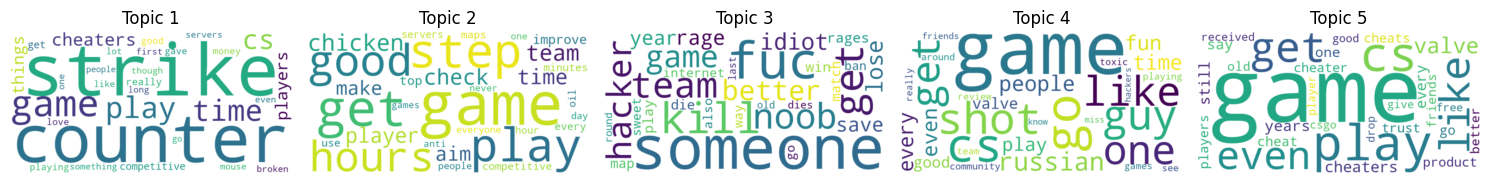

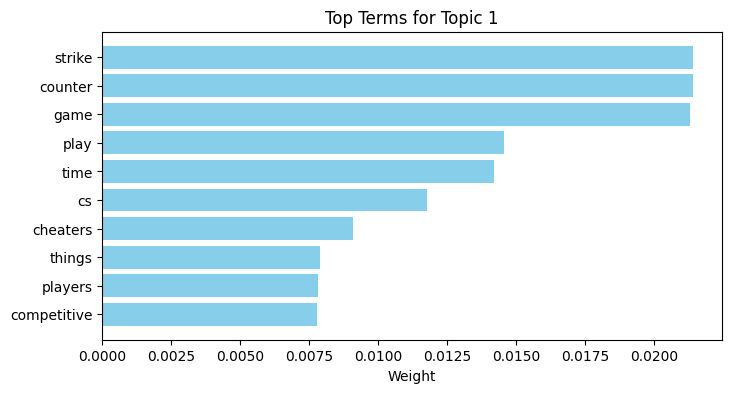

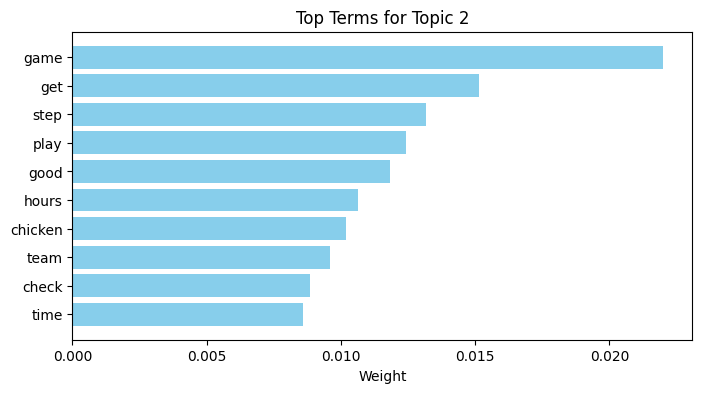

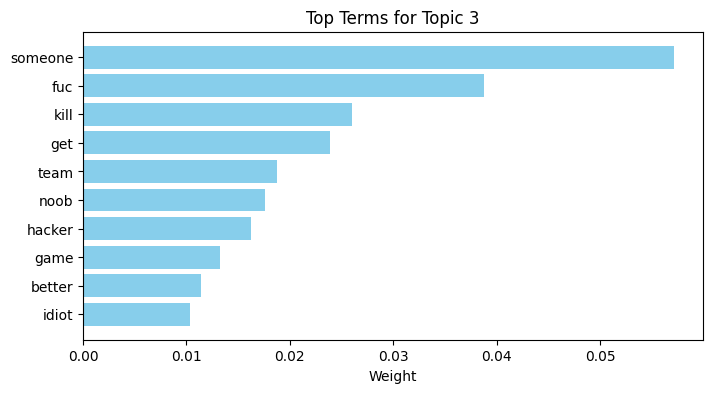

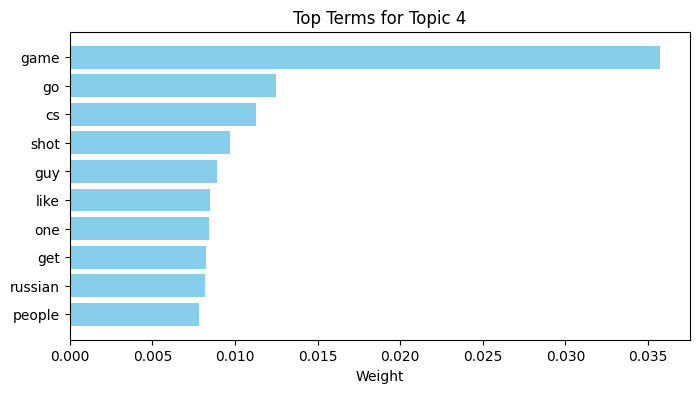

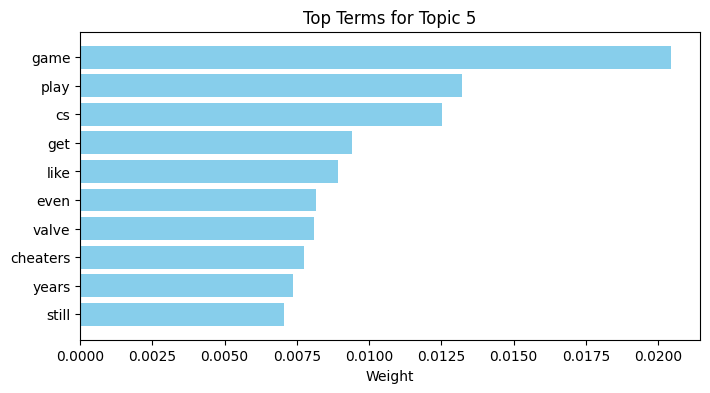

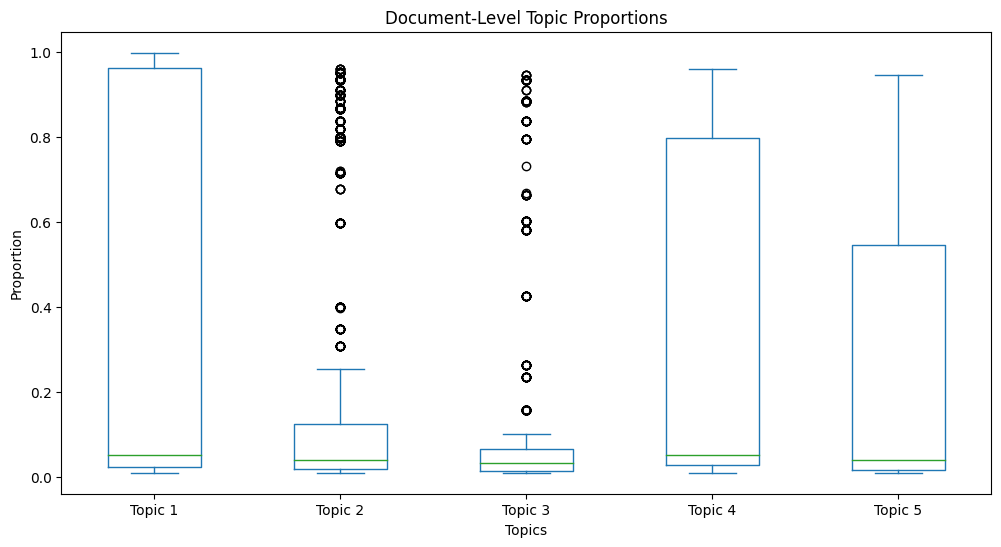

In [26]:
def visualize_wordclouds(model, num_topics, dictionary):
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes[:num_topics]):
        topic_terms = model.show_topic(i, topn=30)
        word_freqs = {term: freq for term, freq in topic_terms}
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freqs)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"Topic {i + 1}", fontsize=12)

    plt.tight_layout()
    plt.show()

# Function to visualize top terms for topics
def visualize_top_terms(model, num_topics):
    for topic_id in range(num_topics):
        topic_terms = model.show_topic(topic_id, topn=10)
        terms, weights = zip(*topic_terms)
        plt.figure(figsize=(8, 4))
        plt.barh(terms, weights, color="skyblue")
        plt.gca().invert_yaxis()
        plt.title(f"Top Terms for Topic {topic_id + 1}")
        plt.xlabel("Weight")
        plt.show()

# Function to visualize document-level topic proportions
def visualize_document_proportions(model, corpus):
    topic_proportions = []
    for doc in corpus:
        topic_dist = model.get_document_topics(doc)
        topic_proportions.append([weight for _, weight in topic_dist])

    topic_proportions_df = pd.DataFrame(topic_proportions, columns=[f"Topic {i+1}" for i in range(model.num_topics)])
    topic_proportions_df.plot(kind="box", figsize=(12, 6), title="Document-Level Topic Proportions")
    plt.xlabel("Topics")
    plt.ylabel("Proportion")
    plt.show()

# Visualize Word Clouds for Topics
visualize_wordclouds(models[5], num_topics=5, dictionary=dictionary)

# Visualize Top Terms for Topics
visualize_top_terms(models[5], num_topics=5)

# Visualize Document-Level Topic Proportions
visualize_document_proportions(models[5], corpus)

# **Step 6: Topic Effect Estimation**
The goal of this step is to estimate how metadata variables influence the prevalence of topics in your documents. This is achieved by fitting regression models that predict topic prevalence based on metadata and visualizing the effects.

Note: you may need to restart the kernel to use updated packages.
Using the 5-topic model...


/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_59888/3550480455.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_ids, y=coefficients, palette="viridis")


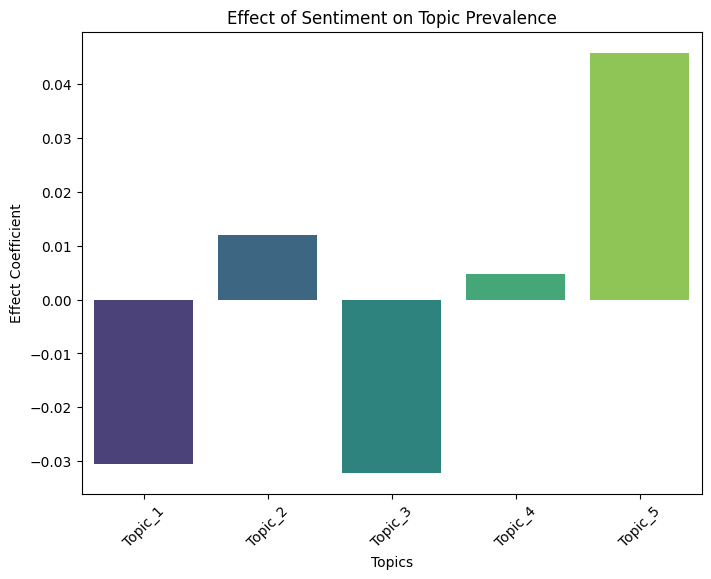

In [33]:
%pip install textblob
from textblob import TextBlob
# Step 1: Extract Topic Proportions

# def extract_topic_proportions(model, corpus):
#     topic_proportions = []
#     for doc in corpus:
#         # Get topic distribution for the document
#         topic_dist = model.get_document_topics(doc, minimum_probability=0)
#         # Convert sparse distribution to dense representation
#         topic_proportions.append(sparse2full(topic_dist, num_terms=model.num_topics))
#     return np.array(topic_proportions)

#chat fix
def extract_topic_proportions(model, corpus):
    topic_proportions = []
    for doc in corpus:
        # Get topic distribution for the document
        topic_dist = model.get_document_topics(doc, minimum_probability=0)
        # Convert sparse distribution to dense representation
        # Removed num_terms argument, sparse2full infers dimensions
        topic_proportions.append(sparse2full(topic_dist, model.num_topics))
    return np.array(topic_proportions)




# Ensure the 5-topic model exists in the dictionary
if 5 in models:
    print("Using the 5-topic model...")
    selected_model = models[5]  # Access the 5-topic model
    topic_proportions = extract_topic_proportions(selected_model, corpus)

    # Step 2: Combine Topic Proportions with Metadata
    topic_columns = [f"Topic_{i+1}" for i in range(selected_model.num_topics)]
    topic_df = pd.DataFrame(topic_proportions, columns=topic_columns)

    # Ensure metadata index matches topic proportions
    metadata = metadata.reset_index(drop=True)
    combined_df = pd.concat([topic_df, metadata], axis=1)

    # Calculate and add Sentiment column
    combined_df['Sentiment'] = data['Review'].apply(lambda text: TextBlob(text).sentiment.polarity)

    # Step 3: Estimate Topic Effects
    # def estimate_effects(combined_df, dependent_vars, independent_var):
    #     results = {}
    #     for topic in dependent_vars:
    #         df = combined_df[[independent_var, topic]].dropna()
    #         X = combined_df[[independent_var]]
    #         y = combined_df[topic]

    #         # Fit a linear regression model
    #         model = LinearRegression()
    #         model.fit(X, y)

    #         # Store coefficients and intercept
    #         results[topic] = {
    #             "Intercept": model.intercept_,
    #             "Coefficients": model.coef_.tolist()
    #         }
    #     return results

    def estimate_effects(combined_df, dependent_vars, independent_var):
          results = {}
          for topic in dependent_vars:
              # Drop rows with NaN values in the relevant columns
              df = combined_df[[independent_var, topic]].dropna()
              X = df[[independent_var]]  # Use the filtered DataFrame
              y = df[topic]            # Use the filtered DataFrame

              # Fit a linear regression model
              model = LinearRegression()
              model.fit(X, y)

              # Store coefficients and intercept
              results[topic] = {
                  "Intercept": model.intercept_,
                  "Coefficients": model.coef_.tolist()
              }
          return results

    # Set dependent variables (topics) and independent variable (metadata column)
    dependent_vars = topic_columns
    independent_var = "Sentiment"  # Example: metadata column for sentiment analysis

    # Run the effect estimation
    effects = estimate_effects(combined_df, dependent_vars, independent_var)

    # Step 4: Visualize Topic Effects
    def plot_effects(effects, independent_var, num_topics=5):
        topic_ids = list(effects.keys())[:num_topics]
        coefficients = [effects[topic]['Coefficients'][0] for topic in topic_ids]

        plt.figure(figsize=(8, 6))
        sns.barplot(x=topic_ids, y=coefficients, palette="viridis")
        plt.title(f"Effect of {independent_var} on Topic Prevalence")
        plt.xlabel("Topics")
        plt.ylabel("Effect Coefficient")
        plt.xticks(rotation=45)
        plt.show()

    # Visualize the effects for the first 5 topics
    plot_effects(effects, independent_var, num_topics=5)
else:
    print("5-topic model not found in the models dictionary.")


# **Step 7: Hierarchical Correlation of Topics**
To compute correlations between topics and visualize topic relationships interactively, we can use the following process:

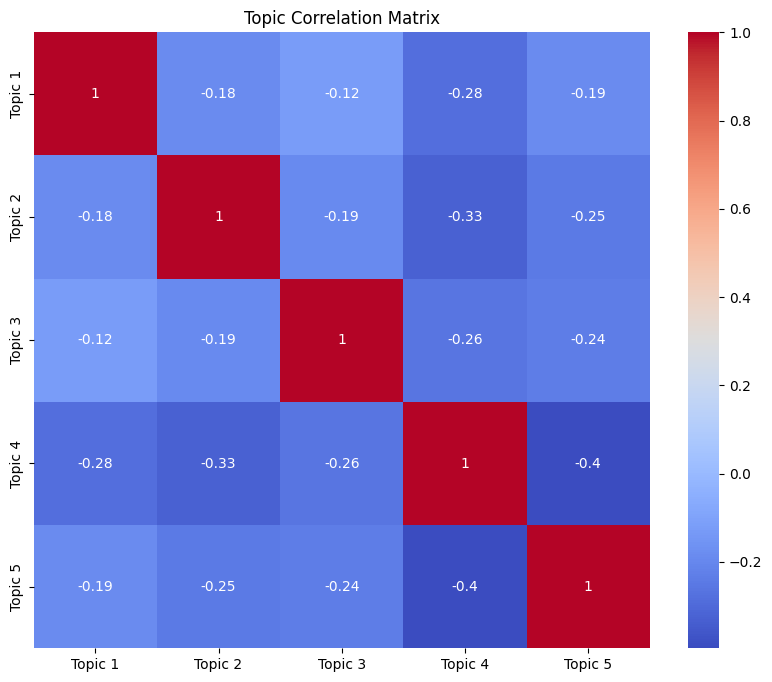

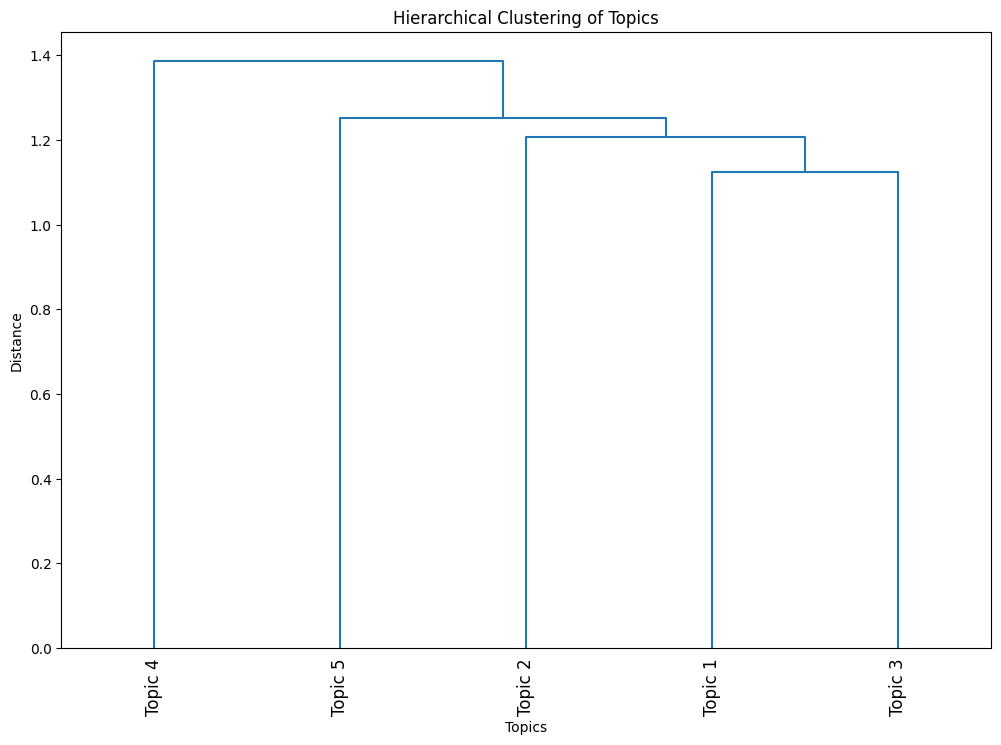

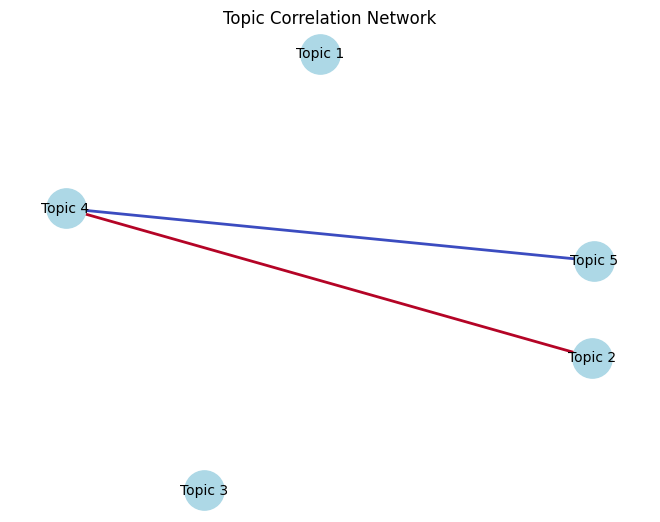

In [34]:
from scipy.spatial.distance import squareform # Import the missing function
def compute_topic_correlations(topic_proportions):
    """
    Compute pairwise correlations between topics based on document-topic proportions.
    """
    correlation_matrix = np.corrcoef(topic_proportions.T)  # Correlation of topics
    return correlation_matrix

# Use the topic proportions from Step 6
if 'topic_proportions' in locals():
    correlation_matrix = compute_topic_correlations(topic_proportions)

    # Step 2: Visualize Correlation Matrix
    def plot_correlation_matrix(correlation_matrix, topic_labels):
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            correlation_matrix,
            annot=True,
            cmap="coolwarm",
            xticklabels=topic_labels,
            yticklabels=topic_labels,
            square=True,
            cbar=True
        )
        plt.title("Topic Correlation Matrix")
        plt.show()

    topic_labels = [f"Topic {i+1}" for i in range(correlation_matrix.shape[0])]
    plot_correlation_matrix(correlation_matrix, topic_labels)

    # Step 3: Visualize Hierarchical Clustering
    def plot_dendrogram(correlation_matrix, topic_labels):
        """
        Plot a dendrogram to visualize hierarchical clustering of topics based on correlations.
        """
        distance_matrix = 1 - correlation_matrix  # Convert correlations to distances
        condensed_distance = squareform(distance_matrix, checks=False)  # Convert to condensed form
        linkage_matrix = linkage(condensed_distance, method='ward')  # Hierarchical clustering

        plt.figure(figsize=(12, 8))
        dendrogram(
            linkage_matrix,
            labels=topic_labels,
            leaf_rotation=90,
            leaf_font_size=12,
            color_threshold=0.5
        )
        plt.title("Hierarchical Clustering of Topics")
        plt.xlabel("Topics")
        plt.ylabel("Distance")
        plt.show()

    plot_dendrogram(correlation_matrix, topic_labels)

    # Step 4: Visualize as a Network Graph
    def plot_topic_network(correlation_matrix, topic_labels, threshold=0.3):
        """
        Plot a network graph of topics where edges represent significant correlations.
        """
        G = nx.Graph()

        # Add nodes
        for i, label in enumerate(topic_labels):
            G.add_node(i, label=label)

        # Add edges for significant correlations
        for i in range(correlation_matrix.shape[0]):
            for j in range(i+1, correlation_matrix.shape[1]):
                if abs(correlation_matrix[i, j]) > threshold:
                    G.add_edge(i, j, weight=correlation_matrix[i, j])

        # Draw the network
        pos = nx.spring_layout(G, seed=42)  # Force-directed layout
        edge_weights = [G[u][v]['weight'] for u, v in G.edges]
        nx.draw(
            G, pos, with_labels=True,
            labels=nx.get_node_attributes(G, 'label'),
            node_size=800,
            node_color="lightblue",
            font_size=10,
            font_color="black",
            edge_color=edge_weights,
            edge_cmap=plt.cm.coolwarm,
            width=2
        )
        plt.title("Topic Correlation Network")
        plt.show()

    plot_topic_network(correlation_matrix, topic_labels)
else:
    print("Topic proportions not found. Ensure Step 6 is completed.")

# **More Advanced Visualisations**

more detailed and insightful visualizations to better understand the results from Structural Topic Modeling (STM). These visualizations include:

Topic Contrast Plots: Visualize the contrast between specific pairs of topics.
Topic-Document Gamma Distributions (Theta Values): Show how much each document contributes to a given topic.
Bar Plots for Top Terms: Highlight the most important terms for each topic.


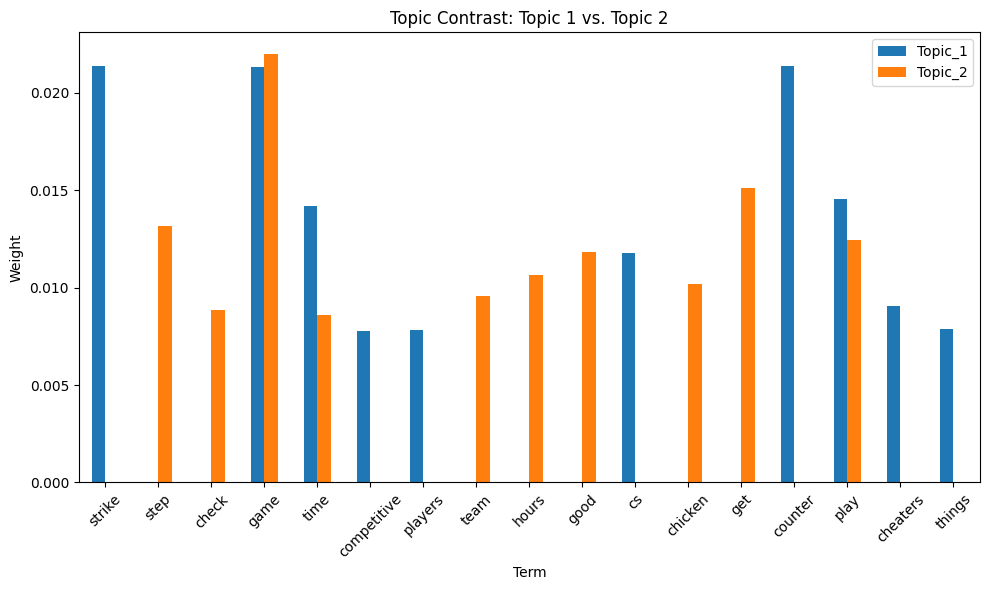

Saved contrast plot to STM_Advanced_Visualizations/topic_contrast_1_2.png


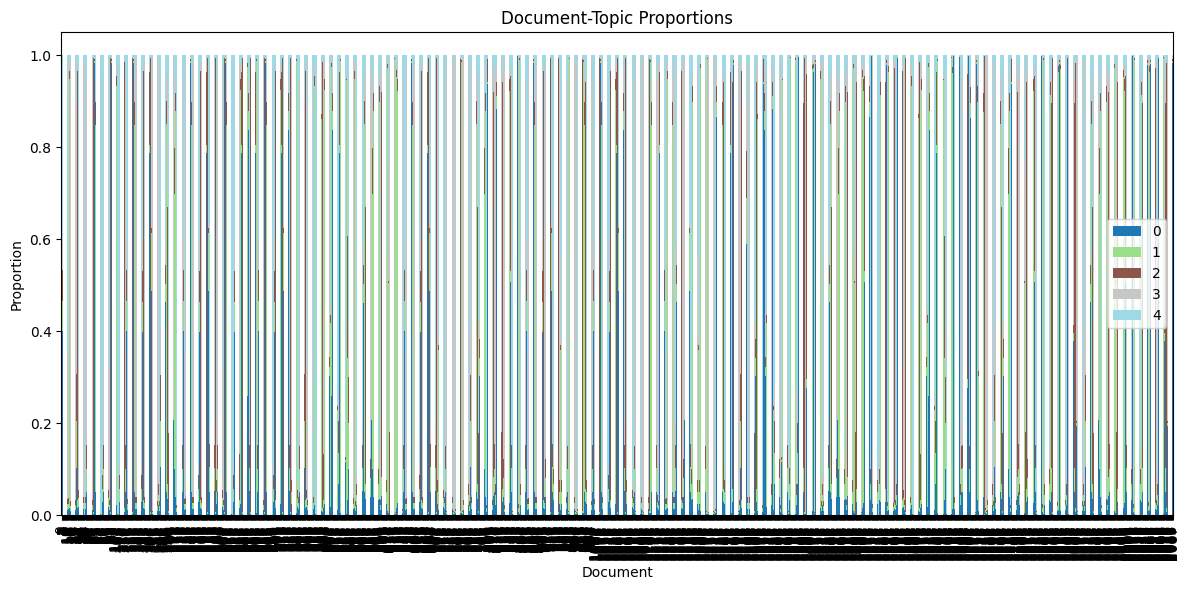

Saved topic proportions plot to STM_Advanced_Visualizations/document_topic_proportions.png


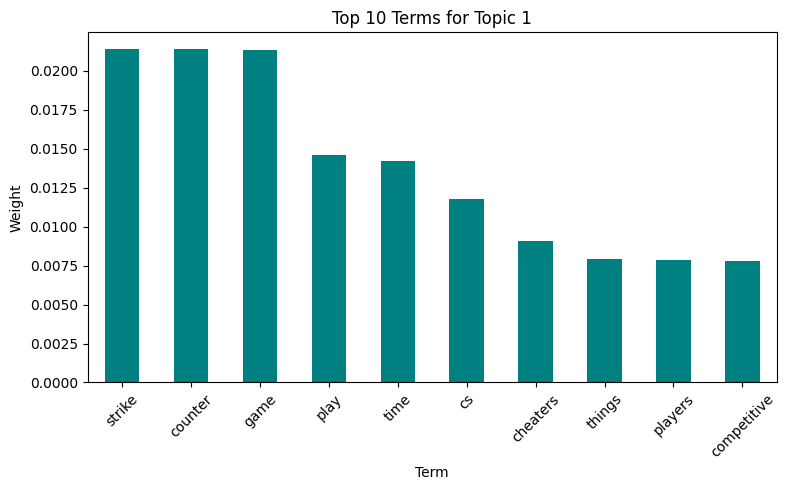

Saved top terms plot for Topic 1 to STM_Advanced_Visualizations/top_terms_topic_1.png


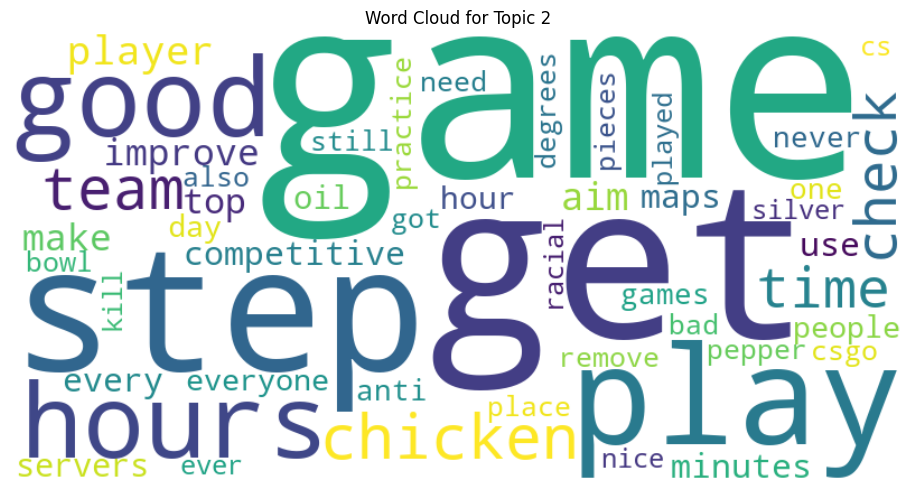

Saved word cloud for Topic 2 to STM_Advanced_Visualizations/wordcloud_topic_2.png


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import os

# Ensure the output directory exists
output_dir = 'STM_Advanced_Visualizations'
os.makedirs(output_dir, exist_ok=True)

# 1. Topic Contrast Plots
def plot_topic_contrasts(model, topic1, topic2, dictionary, num_words=10):
    terms1 = dict(model.show_topic(topic1, num_words))
    terms2 = dict(model.show_topic(topic2, num_words))

    # Combine terms
    all_terms = set(terms1.keys()).union(set(terms2.keys()))
    contrast_df = pd.DataFrame({
        "Term": list(all_terms),
        f"Topic_{topic1+1}": [terms1.get(term, 0) for term in all_terms],
        f"Topic_{topic2+1}": [terms2.get(term, 0) for term in all_terms]
    })

    # Plot
    contrast_df.set_index("Term").plot(kind="bar", figsize=(10, 6))
    plt.title(f"Topic Contrast: Topic {topic1+1} vs. Topic {topic2+1}")
    plt.ylabel("Weight")
    plt.xlabel("Term")
    plt.xticks(rotation=45)
    plt.tight_layout()
    contrast_plot_path = os.path.join(output_dir, f"topic_contrast_{topic1+1}_{topic2+1}.png")
    plt.savefig(contrast_plot_path)
    plt.show()
    print(f"Saved contrast plot to {contrast_plot_path}")

# Example: Compare Topic 0 and Topic 1 from a model
selected_model = models[5]  # For example, the 5-topic model
plot_topic_contrasts(selected_model, 0, 1, dictionary)

# 2. Topic-Document Gamma Distributions (Theta Values)
def plot_topic_proportions(topic_proportions, doc_indices=None):
    if doc_indices is None:
        doc_indices = range(topic_proportions.shape[0])
    topic_df = pd.DataFrame(topic_proportions[doc_indices])
    topic_df.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='tab20')
    plt.title("Document-Topic Proportions")
    plt.xlabel("Document")
    plt.ylabel("Proportion")
    plt.tight_layout()
    proportions_plot_path = os.path.join(output_dir, "document_topic_proportions.png")
    plt.savefig(proportions_plot_path)
    plt.show()
    print(f"Saved topic proportions plot to {proportions_plot_path}")

# Example: Visualize document-topic proportions
plot_topic_proportions(topic_proportions)

# 3. Bar Plots for Top Terms
def plot_top_terms(model, topic_id, num_terms=10):
    terms = model.show_topic(topic_id, num_terms)
    terms_df = pd.DataFrame(terms, columns=["Term", "Weight"]).set_index("Term")
    terms_df.plot(kind='bar', legend=False, figsize=(8, 5), color='teal')
    plt.title(f"Top {num_terms} Terms for Topic {topic_id+1}")
    plt.ylabel("Weight")
    plt.xlabel("Term")
    plt.xticks(rotation=45)
    plt.tight_layout()
    top_terms_plot_path = os.path.join(output_dir, f"top_terms_topic_{topic_id+1}.png")
    plt.savefig(top_terms_plot_path)
    plt.show()
    print(f"Saved top terms plot for Topic {topic_id+1} to {top_terms_plot_path}")

# Example: Visualize top terms for Topic 1
plot_top_terms(selected_model, 0)

# 4. Topic Word Clouds
def generate_word_cloud(model, topic_id, num_words=50):
    terms = dict(model.show_topic(topic_id, num_words))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id+1}")
    plt.tight_layout()
    wordcloud_path = os.path.join(output_dir, f"wordcloud_topic_{topic_id+1}.png")
    plt.savefig(wordcloud_path)
    plt.show()
    print(f"Saved word cloud for Topic {topic_id+1} to {wordcloud_path}")

# Example: Generate word cloud for Topic 2
generate_word_cloud(selected_model, 1)
